# Applying Pretrained Models from Hugging Face

* Author: Johannes Maucher
* Last update: 10.11.23

[Hugging Face](https://huggingface.co) is a platform, which provides pretrained models for a large variety of different Machine Learning tasks. Besides the pretrained models themselves, it also provides means to easily integrate these models in custom Python applications. 

The different ML-task categories, for which Hugging Face provides pretrained models are descibed here: [https://huggingface.co/tasks](https://huggingface.co/tasks):

<img src="https://maucher.home.hdm-stuttgart.de/Pics/tasksHuggingFace.jpg" style="width:800px">


The concept of accessing and integrating a pretrained Hugging Face model is the same for all of the tasks, depicted above. 

In this section we demonstrate the use of Hugging Face models for **Computer Vision** tasks. As already mentioned, the Hugging Face integration for other tasks is similar.

# Import of Images

First we load some images from the local disc and from the web:

In [1]:
#!pip install --upgrade opencv-python

In [2]:
import io
from PIL import Image
import requests
from matplotlib import pyplot as plt
import numpy as np
import cv2

In [3]:
#path="/Users/johannes/ownCloud3/www/web/Pics/sampleimages/"
path="/Users/johannesmaucher/Nextcloud2/www/web/Pics/sampleimages/"
file=path+"mateo.JPG"
imageJump=Image.open(file)
file=path+"Mustang.jpg"
imagePlane=Image.open(file)
file=path+"cat.JPG"
imageCat=Image.open(file)
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image2Cats = Image.open(requests.get(url, stream=True).raw)

imagelist=[imageJump,imagePlane,imageCat,image2Cats]

Display the input images:

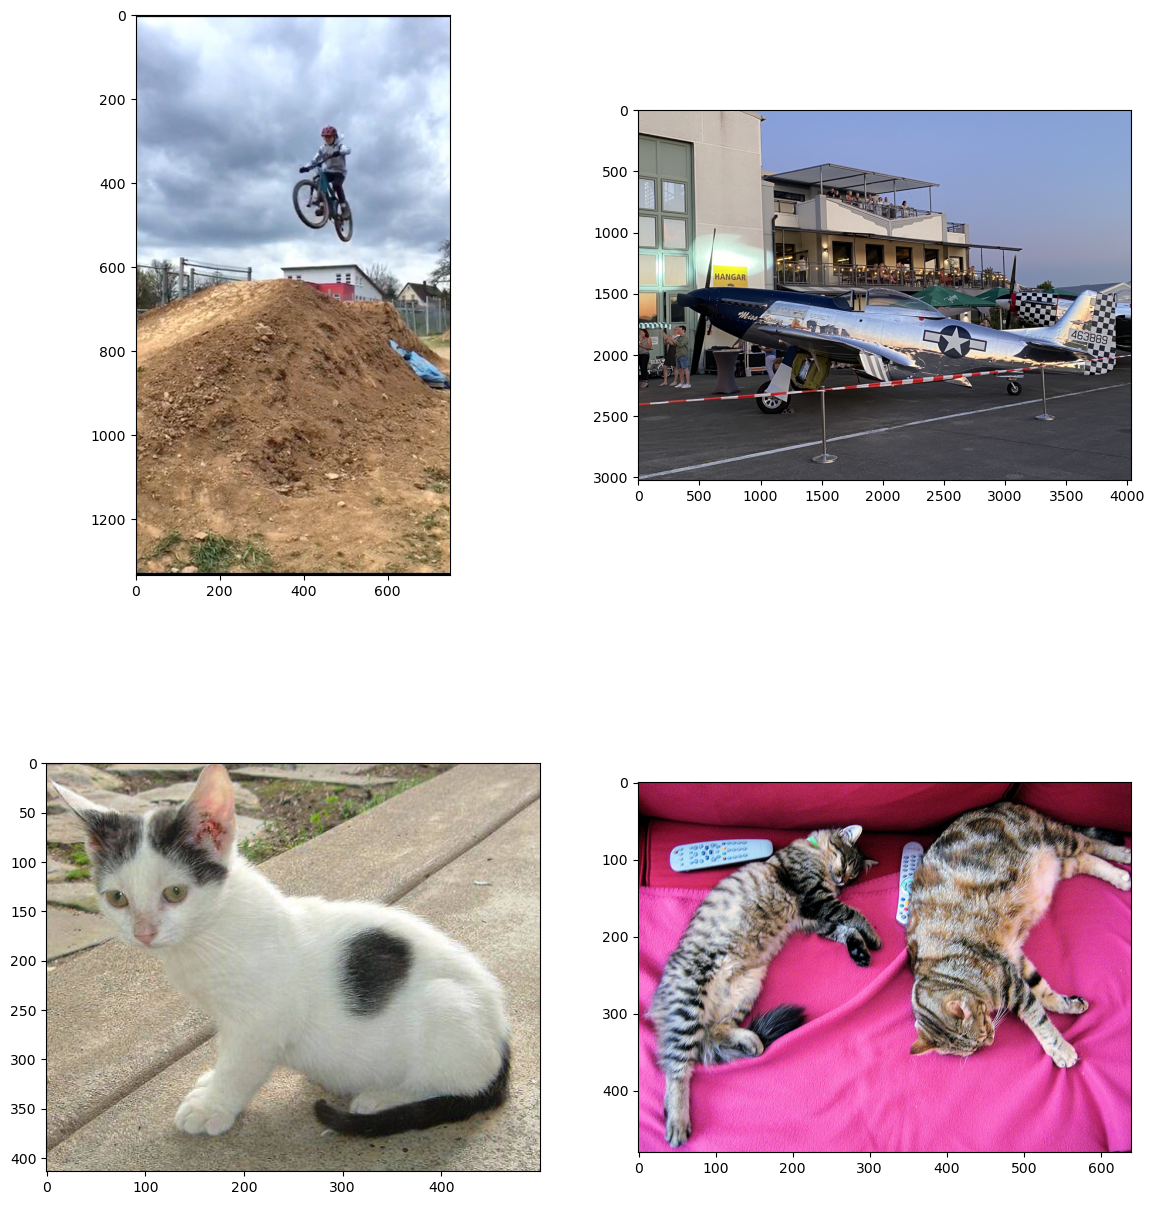

In [4]:
L=len(imagelist)
COLS=2
ROWS=int(np.ceil(L/COLS))
plt.figure(figsize=(14,ROWS*8))
i=1
for im in imagelist:
    plt.subplot(ROWS,COLS,i)
    plt.imshow(im)
    i+=1
plt.show()

# Image Classification

Image classification is the task of assigning a label or class to an entire image. Images are expected to have only one class for each image. Image classification models take an image as input and return a prediction on the class to which the image belongs to.

Below we demonstrate how the [pretrained Hugging Face Vision Transformer model](https://huggingface.co/google/vit-base-patch16-224) can be applied in a Python application.

The Hugging Face package must be installed by

`pip install transformers`


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
from tensorflow.keras.applications.imagenet_utils import decode_predictions

In [18]:
feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [20]:
for image in imagelist:
    print("-"*20+"Next Image"+"-"*20)
    inputs = feature_extractor(images=image, return_tensors="pt")
    outputs = model(**inputs)
    logits = outputs.logits
    sortedclasses=logits[0].detach().numpy().argsort()[::-1]
    TOP=5
    for cl in sortedclasses[:TOP]:
        print("Predicted class:  %18s  %1.3f"%(model.config.id2label[cl],logits[0][cl]))
# model predicts one of the 1000 ImageNet classes
#predicted_class_idx = logits.argmax(-1).item()
#print("Predicted class:", model.config.id2label[predicted_class_idx])

--------------------------------------------------
Predicted class:  mountain bike, all-terrain bike, off-roader  8.653
Predicted class:  worm fence, snake fence, snake-rail fence, Virginia fence  6.369
Predicted class:                 alp  6.168
Predicted class:        crash helmet  5.528
Predicted class:        valley, vale  4.549
--------------------------------------------------
Predicted class:            airliner  10.522
Predicted class:  warplane, military plane  9.008
Predicted class:                wing  8.480
Predicted class:  projectile, missile  7.624
Predicted class:       space shuttle  7.351
--------------------------------------------------
Predicted class:        Egyptian cat  9.070
Predicted class:    tabby, tabby cat  8.855
Predicted class:           tiger cat  8.504
Predicted class:     lynx, catamount  5.543
Predicted class:         Persian cat  4.607
--------------------------------------------------
Predicted class:        Egyptian cat  12.419
Predicted class:   

# Object Detection with the Detection Transformer (DETR)

In object detection the task is to determine for a given input image the classes of the objects in the image and the bounding boxes around the detected objects. Popular Deep Learning approaches for object detection are the different versions of the *R-CNN*-family and *Yolo*. A more recent approach is to apply a transformer and possibly the most prominent transformer for object detection is [Carion et al: End-to-End Object Detection with Transformers (DETR)](https://arxiv.org/abs/2005.12872). The pretrained DETR-model provided by Hugging Face is described in [https://huggingface.co/facebook/detr-resnet-50](https://huggingface.co/facebook/detr-resnet-50).

From the transformers package we import `DetrFeatureExtractor` and `DetrForObjectDetection`.

In [25]:
from transformers import DetrFeatureExtractor, DetrForObjectDetection
import torch

Next, the DETR-feature-extractor and the pretrained DETR-model is loaded:

In [22]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50")

The DETR-feature-extractor is applied to the input image:

In [28]:
image = imagelist[0]
inputs = feature_extractor(images=image, return_tensors="pt")

The extracted features are passed to the input of the pretrained DETR-model and the output contains for each detected object the corresponding class and the bounding box:

In [29]:
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
target_sizes = torch.tensor([image.size[::-1]])
results = feature_extractor.post_process(outputs, target_sizes=target_sizes)[0]

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/transformers/models/detr/modeling_detr.py:423: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


Finally the detected bounding boxes and classes are drawn into the image:

[393, 265, 508, 490]
tensor(1)
Detected person with confidence 0.999 at location [393, 265, 508, 490]
[377, 347, 518, 538]
tensor(2)
Detected bicycle with confidence 0.989 at location [377, 347, 518, 538]


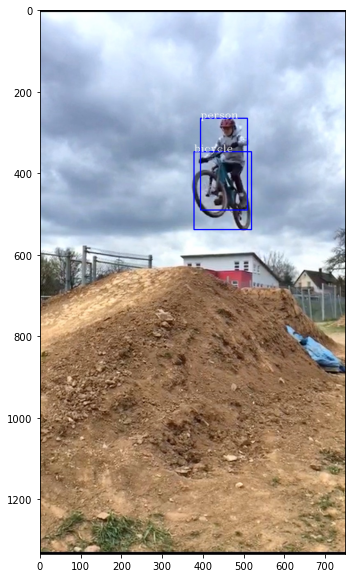

In [30]:
cv2image =np.array(image) 

font = cv2.FONT_HERSHEY_COMPLEX
plt.figure(figsize=(10,10))
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [int(i) for i in box.tolist()]
    # let's only keep detections with score > 0.9
    if score > 0.9:
        print(box)
        print(label)
        text=model.config.id2label[label.item()]
        x1, y1, x2, y2 = box
        cv2.rectangle(cv2image, pt1=(x1, y1), pt2=(x2, y2), color=(0,0,255), thickness=2)
        cv2.putText(cv2image,text,(x1,y1),font,0.8,[255,255,255])
        plt.imshow(cv2image)
        print(
            f"Detected {model.config.id2label[label.item()]} with confidence "
            f"{round(score.item(), 3)} at location {box}"
        )
plt.show()

# Semantic Segmentation

Image Segmentation is the task of dividing an image into segments where each pixel in the image is mapped to an object. Below, we demonstrate how the pretrained [Hugging Face DETR model for segementation](https://huggingface.co/tasks/image-segmentation) can be applied in a Python application.

In [31]:
from transformers import DetrFeatureExtractor, DetrForSegmentation
from transformers.models.detr.feature_extraction_detr import rgb_to_id

In [32]:
image=imagelist[0]

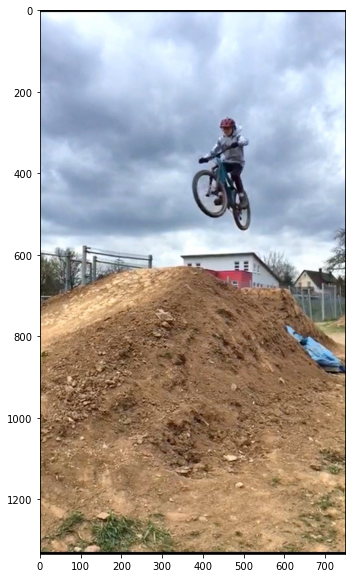

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.show()

In [34]:
feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50-panoptic")
model = DetrForSegmentation.from_pretrained("facebook/detr-resnet-50-panoptic")

# prepare image for the model
inputs = feature_extractor(images=image, return_tensors="pt")

# forward pass
outputs = model(**inputs)

# use the `post_process_panoptic` method of `DetrFeatureExtractor` to convert to COCO format
processed_sizes = torch.as_tensor(inputs["pixel_values"].shape[-2:]).unsqueeze(0)
result = feature_extractor.post_process_panoptic(outputs, processed_sizes)[0]

/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/transformers/models/detr/modeling_detr.py:423: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.embedding_dim)


In [37]:
# the segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(result["png_string"]))
panoptic_seg = np.array(panoptic_seg, dtype=np.uint8)
# retrieve the ids corresponding to each mask
panoptic_seg_id = rgb_to_id(panoptic_seg)

In [38]:
panoptic_seg.shape

(1332, 749, 3)

In [39]:
panoptic_seg_id.shape

(1332, 749)

In [40]:
maxval=panoptic_seg_id.max()

In [41]:
cv2segim =np.array(panoptic_seg_id/maxval) 

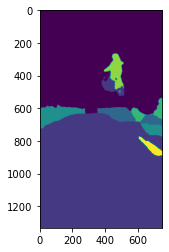

In [42]:
plt.imshow(cv2segim)

(array([430527., 491228.,      0.,  20119.,      0.,  27368.,   9110.,
             0.,  13225.,   6091.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <BarContainer object of 10 artists>)

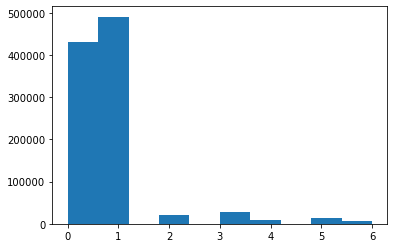

In [43]:
plt.hist(panoptic_seg_id.flatten())

# Text-based Image Retrieval

In this section we apply the [pretrained CLIP model from Hugging Face](https://huggingface.co/docs/transformers/model_doc/clip) for calculating similarities between images and texts.

CLIP is a multi-modal vision and language model, which can be applied to calculate similarities between image-text-pairs. CLIP uses 
* a ViT like transformer to get visual features and 
* a causal language model to get the text features. 

Text- and visual features are then projected to a common latent space. The dot product between the projected image and text features is then used as a similar score.


In [45]:
from transformers import CLIPProcessor, CLIPModel

In [46]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


## Find text, which describes given image

In [47]:
image=imagelist[2]

In [48]:
inputs = processor(text=["a photo of a cat", "a photo of a dog", "a photo of an astronaut"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

In [52]:
probs

tensor([[9.9642e-01, 3.3617e-03, 2.2046e-04]], grad_fn=<SoftmaxBackward0>)

From the output of the previous code-cell we conclude, that the first text `a photo of a cat` matches best to the given image. 

## Find image, which best matches to the query text

In [57]:
inputs = processor(text="a fighter plane", images=imagelist, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=0)  # we can take the softmax to get the label probabilities

In [58]:
probs

tensor([[6.8380e-04],
        [9.8987e-01],
        [4.0579e-03],
        [5.3893e-03]], grad_fn=<SoftmaxBackward0>)

From the output of the previous code-cell we conclude, that the second image matches best to the given text-query. 